# Is there any difference between the proportions of high-school regular smokers in British Columbia and Ontario?

In [1]:
library(tidyverse)
library(haven)
library(infer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Introduction (430 words)

#### Why we're interested in the topic
Smoking becomes a common phenomenon among teenagers even though they know the negative effects of it. The prevalence of tobacco products makes it both more tempting to try and harder to quit for teenagers (Burton et al.). Scholars studying student smoking rates in ON (Reitsma and Manske) and BC (Johnson et al.) claim that the issue needs more attention as it causes severe health problems. ***We chose those two regions because !!!***. Hence, our research analyses the problem by finding the **difference between the proportions of high-school regular smokers in British Columbia and Ontario**.

Most smokers are aware of the negative effects of smoking. But there are biological and sociological factors which are preventing them from quitting it. That is, from one side many of the ingredients in tobacco products are addictive, so they cause the physiological demand (Burton et al.). From the other perspective, smokers who want to quit experience sociological pressure as their peers may consume tobacco products daily, i.e., those who want to quit might see others smoking and smell the cigarettes (Burton et al.). Thus, biological and sociological factors make it hard to quit smoking. However, if those willing to quit surround themselves with ex-smokers, their prospects of removing the cigarette addiction become much more viable (Burton et al.).

#### Why our data set is reliable
We use the data obtained by *Health Canada’s 2018/2019 Canadian Student Tobacco, Alcohol and Drugs Survey (CSTADS)* which is a biennial school-based Health Canada's survey constructed in 2018/2019 that studies smoking rates among Canadian students in grades 7 through 12 (Canada and Impact). This data set is relatively new, and because of the reasons outlined below we think that this set is trustworthy.

CSTADS has been conducted since 1994, and starting from 2016/2017 survey, they expanded the survey coverage to grades 9-12 as those students were generally more involved in smoking. This procedure change made the survey more focused and allowed us to use their data set as high-school students is the target population of our research paper.

Moreover, to further improve the survey methodology and understand the causes behind smoking, the scientists considered other factors that may affect tobacco consumption. By surveying school staff and administrators, students and the parents, they found that alcohol use, drugs, bullying and even sleep related problems may cause smoking. Furthermore, the student sample collection procedure was very rigorous. They used a "stratified single stage cluster" design which allowed them to get "adequate sample sizes inside the strata and increased precision" (Canada and Impact). Thus, the data collection methodology ensured independence between observations, and therefore, greatly reduced the bias.

Thus, based on all the arguments above, we conclude that this data set is trustworthy.

## Variables (149 words)
The variables we choose are aimed at defining our custom boolean variable that determines whether a data set observation is a high-school student who is a regular smoker. Using these parameters, we can filter our data set to only contain the population of interest, i.e., high-school students from BC and ON.

We then use our derived variable `regular_smoker` to calculate the proportion of students who regularly smoke in those provinces.

#### How we define population
Here are the variables that allow us to filter the data and obtain the subset representing the population we're interested in.

| Variable   	| Value    	| Meaning                                                    	|
|------------	|----------	|------------------------------------------------------------	|
| **GRADE**  	| [9, 12]  	| student is from a grade 9 to 12                            	|
| **PROVID** 	| 35 or 59 	| **35** - student is from ON<br>**59** - student is from BC 	|

#### How we derive our custom variable
Our data set has many variables, so we can use these ones to precisely define our **regular smoker**.

| Variable   	| Value  	| Meaning                                                                                                                        	|
|------------	|--------	|--------------------------------------------------------------------------------------------------------------------------------	|
| **DVRES**  	| 1 or 3 	| **1** - resident of Canada, <br>**3** - lived in Canada for 11+ years                                                          	|
| **TS_011** 	| 1 or 2 	| **1** - will *definitely* smoke a cigarette within next year<br>**2** - will *probably* smoke a cigarette within next year         	|
| **TV_010** 	| 1 or 2 	| **1** - will *definitely* smoke an e-cigarette within next year<br>**2** - will *probably* smoke an e-cigarette within next year 	|
| **SS_040** 	| 1      	| **1** - smoked 100+ cigarettes                                                                                                 	|
| **SS_060** 	| 8 	| **8** - smoked every day in the last month                                    	|
| **WP_030** 	| 3 or 6 	| **3** - smoked every day in the past week<br>**6** - smoked on weekdays and weekends, but not every day                        	|                   	|

* `TS_011` and `TV_010` show that a student is intending to smoke within the next year, which would be a characteristic of a regular smoker
* `SS_040`, `SS_060`, and `WP_030` all show that the given individual has a history of smoking regularly

Thus, our **regular smoker** is a high-school student from BC or ON whose smoking habits correspond to the variables above.

## Methods

We're conducting a hypothesis test of the difference between the proportions of high-school smoking students in BC and ON. 

#### Paper outline
* Calculate point estimate and make preliminary conclusions
* Use infer workflow to generate a null distribution
* Conduct the hypothesis test using p-value
    * Plot the null distribution with the p-value
    * Decide on the rejection of H<sub>0</sub>
* Use infer workflow to generate a bootstrap distribution
* Conduct the hypothesis test using CI
    * Plot the bootstrap distribution with the CI endpoints
* Compare the results of the p-value and CI approaches
* Evaluate the findings and suggest further improvements

## Preliminary Data Analysis (344 words)

#### Reading the data

In [2]:
set.seed(1234)

# Reading the data and presenting the first few rows of it as a table
data <- read_sav("./data/dataset.sav")
data %>%
  head()

# Default text size for the plots
text_size <- 18

SCANID,MODULE,PROVID,SCHID,GRADE,SEX,SS_010,SS_020,TS_011,TV_010,⋯,DVTY2ST,DVLAST30,DVAMTSMK,DVCIGWK,DVNDSMK,DVAVCIGD,DVRES,DVURBAN,DVHHINC2,WTPP
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,⋯,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>
100224,1,35,3589267,9,1,1,13,2,3,⋯,1,1,1,8,5,2,1,2,60000,33.15
100225,1,35,3589267,9,1,1,13,1,1,⋯,1,1,10,70,7,10,1,2,60000,33.15
100226,1,35,3589267,12,1,2,NA,4,3,⋯,7,2,NA,NA,NA,NA,3,2,60000,75.14
100227,1,35,3589267,12,2,1,NA,3,2,⋯,4,1,0,0,0,0,1,2,60000,105.70
100228,1,35,3589267,12,1,1,NA,3,3,⋯,6,2,NA,NA,NA,NA,1,2,60000,75.14
100229,1,35,3589267,11,1,2,NA,4,3,⋯,7,2,NA,NA,NA,NA,1,2,60000,63.87


#### Exploratory analysis

As described above, we're going to study students from BC and ON and use the derived categorical variable called `regular_smoker`. This boolean variable can be `yes` or `no`, which specifies whether the observed high-school student is a regular smoker.

In [3]:
# Using the "Variables" section table values,
# this code creates a new column `regular_smoker` and
# filters the data set to contain only observations of BC and ON students

tidy_data <- data %>%
  filter(GRADE %in% 9:12,
         PROVID == 35 | PROVID == 59) %>%
  mutate(regular_smoker = if_else(
    ((DVRES == 1 | DVRES == 3) &
      (TS_011 %in% 1:2) &
      (TV_010 %in% 1:2) &
      (SS_040 == 1) &
      (SS_060 == 8) &
      (WP_030 == 3 | WP_030 == 6)),
    "yes", "no"
  )) %>%
  filter(!is.na(regular_smoker)) %>%
  mutate(province = as_factor(PROVID),
         grade = as_factor(GRADE)) %>%
  arrange(province) %>%
  select(province, grade, regular_smoker)

tidy_data %>%
  tail(3)

province,grade,regular_smoker
<fct>,<fct>,<chr>
British Columbia,Grade 10,no
British Columbia,Grade 10,no
British Columbia,Grade 10,no


We can also find how many observations our filtered data set has.

In [4]:
tidy_data %>%
  group_by(province) %>%
  summarise(obs_count = n())

province,obs_count
<fct>,<int>
Ontario,2754
British Columbia,4244


The sample size is sufficiently large, but we don't trim it to have same number of observations in each category. The higher number of observations would only improve our analysis as the obtained sample would be more representative of the population. Referring to the data-collection procedure above, we also assume that this sample is not biased, and therefore we can proceed with the analysis.

Now we visualize our obtained data to visually estimate the difference in the proportion of smoking students.

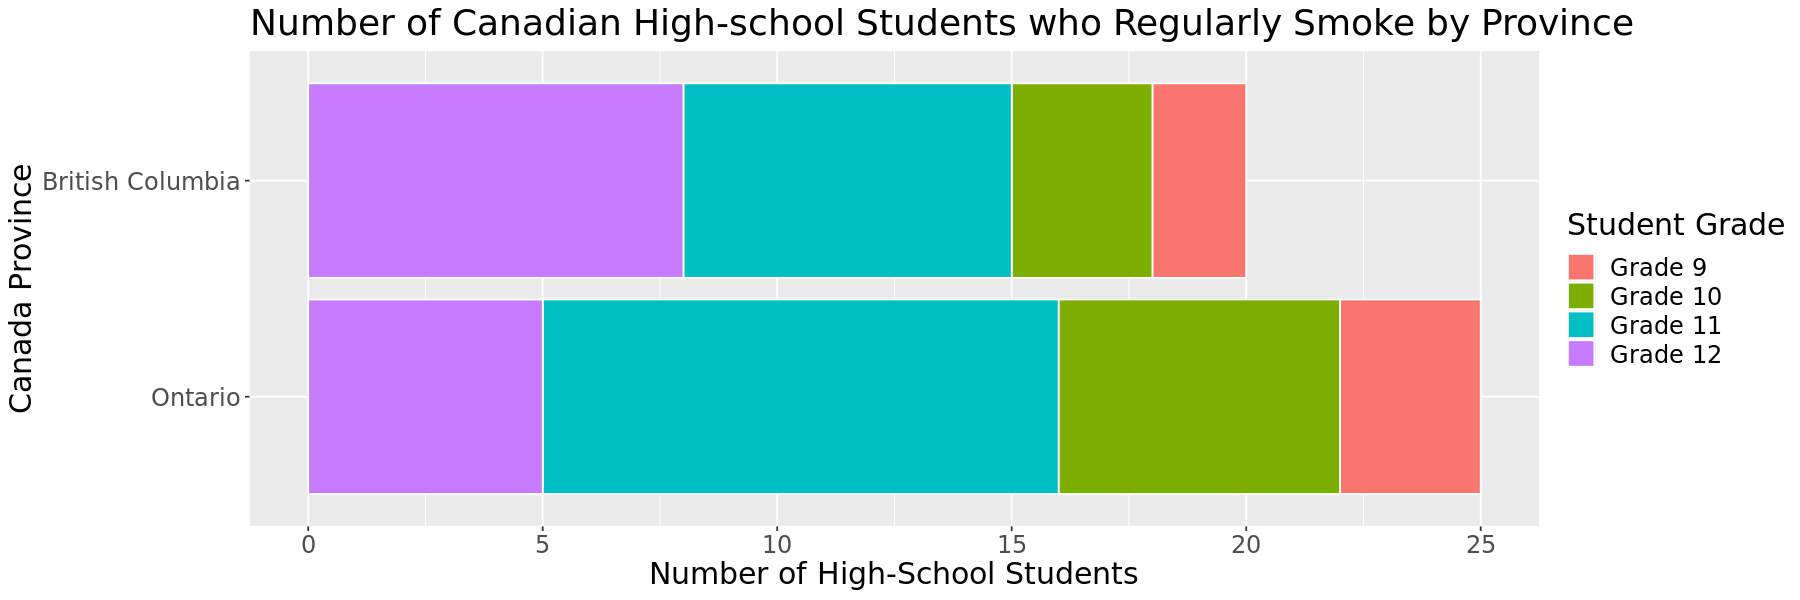

In [5]:
options(repr.plot.width = 15, repr.plot.height = 5)

# The bar chart is colored by the `grade` variable
# to allow us to get a further insight into the data

tidy_data %>%
  filter(regular_smoker == "yes") %>%
  ggplot(aes(x = province, fill = grade)) +
  geom_bar(color = "white") +
  labs(title = "Number of Canadian High-school Students who Regularly Smoke by Province",
       x = "Canada Province",
       y = "Number of High-School Students",
       fill = "Student Grade") +
  coord_flip() +
  theme(text = element_text(size = text_size))

The chart tells us that in BC and ON, high-school students are involved in smoking regardless of their grade. Also, it shows that the proportion in ON is larger, so we infer that there is a difference in the true proportion rates.

#### Point estimate calculation

From this point on, we don't consider `grade` as a variable because we're interested in studying all BC and ON high-school students in general. This approach inevitable introduces some ambiguity, but we think the **high-school student** a term is specific enough for our study.

In [6]:
# Removes the `grade` column
sample <- tidy_data %>%
  select(-grade)

# Shows all possible combinations of our data set rows
sample %>%
  distinct()

province,regular_smoker
<fct>,<chr>
Ontario,no
Ontario,yes
British Columbia,no
British Columbia,yes


Next, we need to find the proportions of regular smokers in each province.

In [7]:
# We group our data set by the `province` variable and
# calculate the proportion of observations that have `regular_smoker` variable set to `yes`

# Here we use the mean function to quickly calculate the needed proportions
sample_proportions <- sample %>%
  group_by(province) %>%
  summarise(prop = mean(regular_smoker == "yes"))
sample_proportions

province,prop
<fct>,<dbl>
Ontario,0.009077705
British Columbia,0.004712535


Finally, the code below finds the **point estimate** or so-called **observed test statistic** by subtracting **the BC proportion from the ON proportion**, i.e., **p̂ = p<sub><sub>ON</sub></sub> - p<sub><sub>BC</sub></sub>**

In [8]:
point_estimate <- 
  sample_proportions$prop[1] - sample_proportions$prop[2]

point_estimate

[1] 0.00436517

#### Why further analysis is required
The point estimate found above tells there is a difference in the true proportions. However, it doesn't take into consideration the standard error associated with the sample we used, i.e., the sample we obtained may not be representative because the true population might have great variability and different samples would give drastically different results.

Therefore, we cannot report the value above. Instead, in the next section we'll use Hypothesis Testing and Confidence Intervals to estimate our sample's degree of uncertainly and provide a more reliable result.

## Data analysis

In this section we perform more in-depth analysis by doing hypothesis testing using both p-value and Confidence Interval (CI) approaches.

#### Null and Alternative Hypothesis

**H<sub>0</sub>: p<sub><sub>ON</sub></sub> - p<sub><sub>BC</sub></sub> = 0**, i.e., the proportions of high-school regular smokers in BC and ON are the same

**H<sub>A</sub>: p<sub><sub>ON</sub></sub> - p<sub><sub>BC</sub></sub> $\neq$ 0**, i.e., there is a difference between the proportions of BC and ON high-school regular smokers

Following the Hypothesis Testing procedure, we assume **H<sub>0</sub>**, i.e., we assume that there's no difference in the proportions. **H<sub>A</sub>** in this case is an alternative hypothesis that is used challenge our assumption and allow us to see if there's enough evidence to reject it.

#### Specifying significance level
For our analysis, we're going to use **$\alpha$ = 0.05**. This small yet frequently used value ensures that as researches, we'll need to have significant evidence against the null hypothesis **H<sub>0</sub>** in order to reject it.

#### Generation of a null distribution 

Here's an outline of the null distribution generation:
1. In the **specify** step we put `formula = regular_smoker ~ province` as we want to study whether `province` has an influence on the `regular_smoker` status. We also specify `success = yes` because we're interested in the proportion of students who regularly smoke

2. In the **hypothesize** step we put `null = "independence"` because our sample has two groups of observations — regular smokers and others — and we want to test if our response variable `regular_smoker` is dependent on the explanatory variable `province`

3. The **generate** step allows to generate 1000 samples from our data sample. This resample count is sufficiently large to reduce the sample variability. Also, we set `type = "permute"` which generate samples *without replacement*. We used this setting because it's more suitable for conducting a hypothesis test, while the bootstrapping is better for constructing CI intervals

4. The **calculate** step is used to find the summary test statistics for each generated sample. Since our unknown population parameter is the difference in proportions **p<sub><sub>ON</sub></sub> - p<sub><sub>BC</sub></sub>**, the test statistics are calculated the same way but using data of each resample, i.e., **p̂<sub><sub>ON</sub></sub> - p̂<sub><sub>BC</sub></sub>**. Thus, we set `stat = "diff in props"`. Additionally, it's very important to specify the order of subtraction and keep it consistent. We did this while finding the `point_estimate`, so here we keep it same by using `order = c("Ontario", "British Columbia")`

In [22]:
# this code implements all the steps from above
null_distribution <- sample %>%
  droplevels() %>%
  specify(formula = regular_smoker ~ province, success = "yes") %>%
  hypothesize(null = "independence") %>%
  generate(reps = 1000, type = "permute") %>%
  calculate(stat = "diff in props", order = c("Ontario", "British Columbia"))

# preview the null distribution
null_distribution %>%
  head(3)

# count how many observations the null distribution has
null_distribution %>%
  nrow()

replicate,stat
<int>,<dbl>
1,-0.00162218
2,0.00197023
3,-0.00042471


[1] 1000

The data frame above has 1000 instances of variable `stat` representing **p̂<sub><sub>ON</sub></sub> - p̂<sub><sub>BC</sub></sub>**. Since every `stat` value was computed assuming the truth of the null hypothesis **H<sub>0</sub>**, we call this data set `null_distribution`.

#### Testing using a p-value approach

In [10]:
# remind ourselves the calculated point estimate value
point_estimate

[1] 0.00436517

In this step we visualize our `point_estimate` as a red line, put it against the `null_distribution`, and use a **p-value** to measure how "surprised" we are by the point estimate if we assume that **H<sub>0</sub>** is true. **P-value** is shown as a shaded region representing the probability of getting a test statistic that is same or greater than our test statistic stored in a `point_estimate`.

Thus, this approach allows us to visually estimate if there's enough evidence to reject **H<sub>0</sub>**.

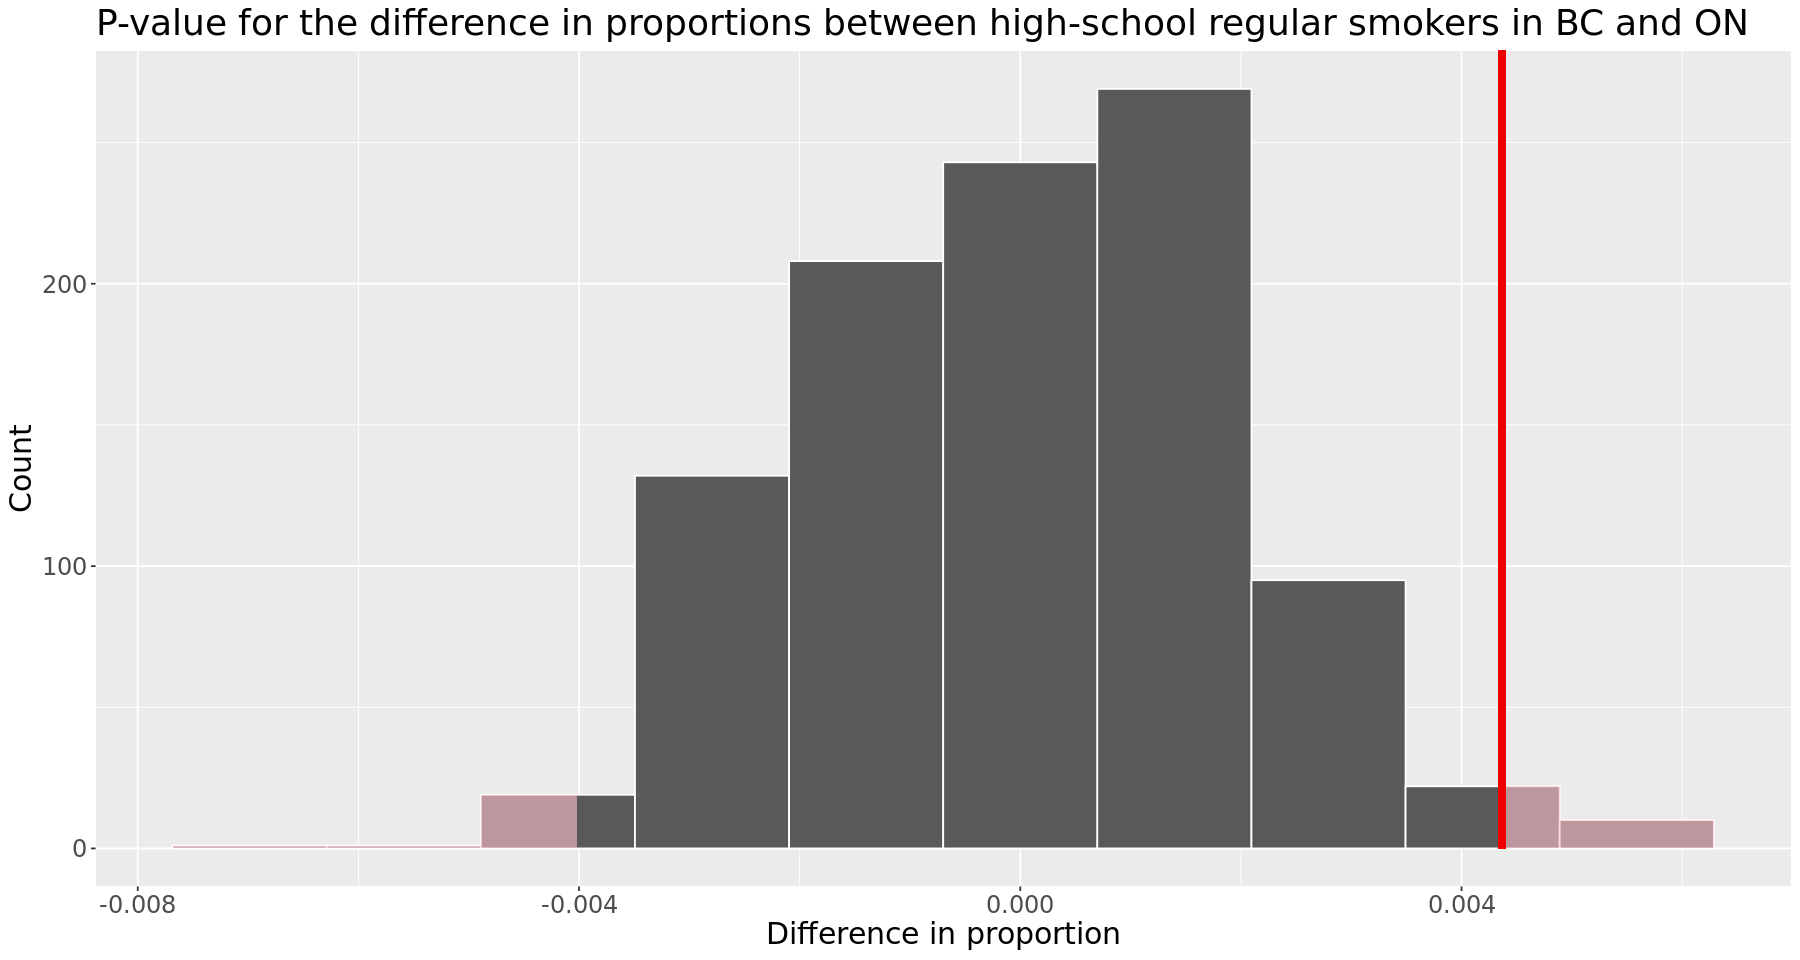

In [23]:
options(repr.plot.width = 15, repr.plot.height = 8)

visualise(null_distribution, bins = 10) +
  shade_pvalue(obs_stat = point_estimate, direction = "both") +
  labs(title = "P-value for the difference in proportions between high-school regular smokers in BC and ON",
       x = "Difference in proportion",
       y = "Count") +
  theme(text = element_text(size = text_size))

The histogram above shows that the shaded region representing p-value is small, so we're inclined to reject **H<sub>0</sub>**.

In [12]:
# computing the exact p-value
p_val <- null_distribution %>%
  get_pvalue(obs_stat = point_estimate, direction = "both")
p_val

p_value
<dbl>
0.036


The p-value shown above says that there's a 3.6% chance that we observe the value of our `point_estimate` in the situation when **H<sub>0</sub>** is true. Considering that we specified our significance level $\alpha$ = 0.05 (5%) and that the calculated p-value is smaller than it, **we reject the null hypothesis H<sub>0</sub>**.

Therefore, using the p-value approach, we conclude that **there's enough evidence to suggest that there is a difference between the true proportions of high-school regular smokers in BC and ON under a 5% significance level**.

#### Testing using a confidence interval approach

In this section we conduct the same test as before but using a CI approach as this would allow as to justify the conclusion made above.

Due to the nature of the infer package, we don't have to make a lot of modifications to the null distribution generation procedure from above, so here we outline just the changes we made:

1. We removed the **hypothesize** step because we don't need it to build a CI
2. In the **generate** step we set `type = "bootstrap"` because bootstrapping is used to build confidence intervals

The code below constructs a bootstrap distribution of our sample:

In [13]:
bootstrap_distribution <- sample %>%
  droplevels() %>%
  specify(formula = regular_smoker ~ province, success = "yes") %>%
  generate(reps = 1000, type = "bootstrap") %>%
  calculate(stat = "diff in props", order = c("Ontario", "British Columbia"))

# preview the bootstrap distribution
bootstrap_distribution %>%
  head(3)

replicate,stat
<int>,<dbl>
1,0.003701078
2,0.002618129
3,0.007741654


Now we can use this distribution to construct a 95% confidence interval for **p<sub><sub>ON</sub></sub> - p<sub><sub>BC</sub></sub>**.

In [14]:
ci <- bootstrap_distribution %>%
  get_ci(level = 0.95, type = "percentile")
ci

lower_ci,upper_ci
<dbl>,<dbl>
0.0003920954,0.00854427


The CI endpoints found above tell us that we're 95% "confident" that the true proportion difference **p<sub><sub>ON</sub></sub> - p<sub><sub>BC</sub></sub>** is between 0.0003920954 and 0.00854427.

We visualize this CI in the plot below.

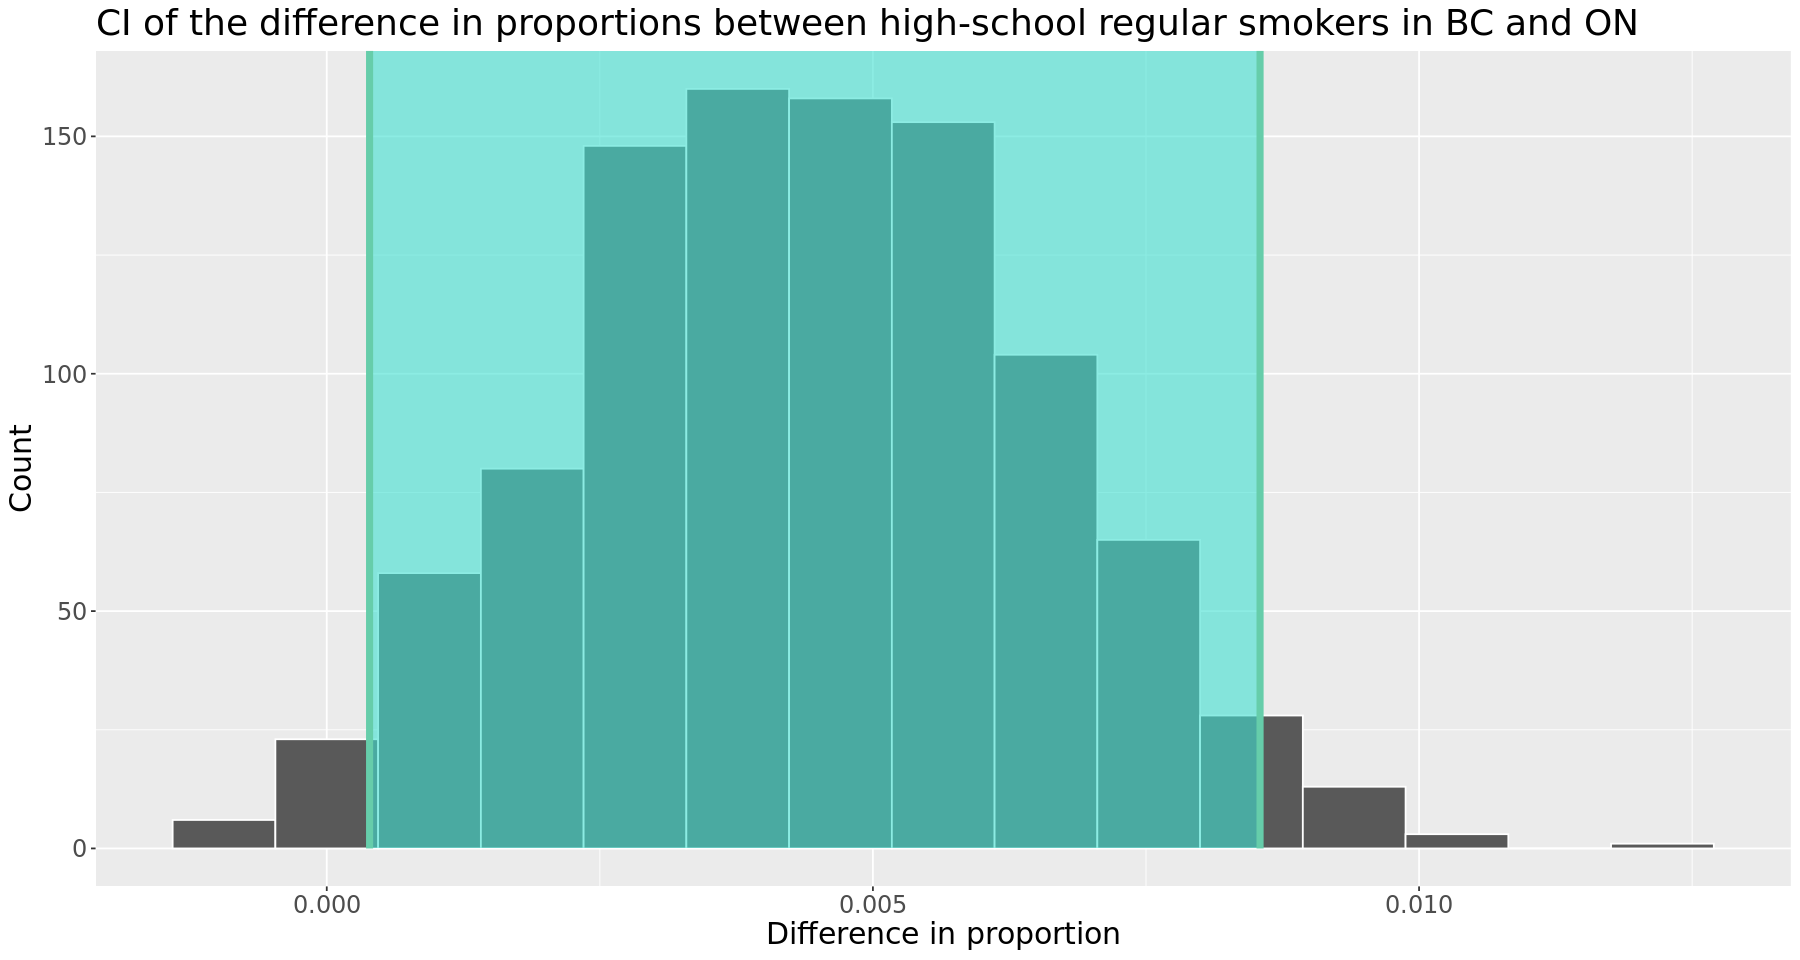

In [20]:
visualise(bootstrap_distribution) +
  shade_ci(endpoints = ci) +
  labs(title = "CI of the difference in proportions between high-school regular smokers in BC and ON",
     x = "Difference in proportion",
     y = "Count") +
  theme(text = element_text(size = text_size))

As the histogram above shows, the constructed CI does not include the value 0. From this we conclude that, based on the data set we used, all high-school students in ON and BC have truly different smoking habits. Moreover, since all values in the interval are above 0, our data suggests that ON has a greater proportion of high-school students who regularly smoke.

Thus, the CI approach confirmed our conclusion from the p-value test, so we can confidently report that **there is a significant difference between the proportions of high-school regular smokers in BC and ON**.

## Evaluation

#### Expectations
We expect the true proportion difference to be a small value because our graph above and the point estimate show that there's a little difference between the sample proportions.

#### Future questions
Others can extend our research question by comparing the proportions of high-school smoking students between other Canadian provinces.
Using data obtained from such a study would let us know if we can extrapolate the data for students throughout Canada using this study, or if the data is not representative which would disallow extrapolation as a method. 

## References
Burton, Suzan, et al. “‘Smoking Is Bad, It’s Not Cool…yet
I’m Still Doing It’: Cues for Tobacco Consumption in a ‘Dark’ Market.” *Journal
of Business Research*, vol. 68, no. 10, 1 Oct. 2015, pp. 2067–2074,
www.sciencedirect.com/science/article/pii/S0148296315001186, 10.1016/j.jbusres.2015.03.004.
Accessed 14 Dec. 2021.

Canada, Health, and PROPEL Centre for Population Health
Impact. “2018/2019 Canadian Student Tobacco, Alcohol and Drugs Survey.” *Abacus.library.ubc.ca*,
18 Nov. 2020, abacus.library.ubc.ca/dataset.xhtml?persistentId=hdl:11272.1/AB2/WEFOHY.
Accessed 1 Mar. 2022.

Johnson, Joy L., et al. “Socio-Demographic Correlates of
Cigarette Smoking among High School Students.” *Canadian Journal of Public
Health*, vol. 95, no. 4, July 2004, pp. 268–271, 10.1007/bf03405129.
Accessed 5 May 2020.

Reitsma, Angela H., and Steve Manske. “Smoking in Ontario
Schools.” *Canadian Journal of Public Health*, vol. 95, no. 3, May 2004,
pp. 214–218, 10.1007/bf03403652. Accessed 29 Oct. 2019.

**Word Count: 623**